In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import sys
parent_path = str(Path().joinpath('..').resolve())
sys.path.append(parent_path)

In [3]:
from triple_agent.parsing.replay.get_parsed_replays import get_parsed_replays
from triple_agent.reports.generation.plot_specs import AxisProperties, DataQueryProperties
from triple_agent.constants.events import select_scl5
from triple_agent.reports.generation.generic_query import query
from triple_agent.classes.game import Game
from triple_agent.classes.timeline import TimelineCategory
from triple_agent.classes.missions import Missions

In [4]:
scl5_replays = get_parsed_replays(select_scl5)

In [5]:
def _flirt_in_15_seconds(games, data_dictionary):
    for game in games:
        for timeline_event in game.timeline:
            if (
                timeline_event.category & TimelineCategory.ActionTest
                and timeline_event.mission & Missions.Seduce
            ):
                data_dictionary[True] += 1
                break
                
            if timeline_event.elapsed_time > 15:
                data_dictionary[False] += 1
                break

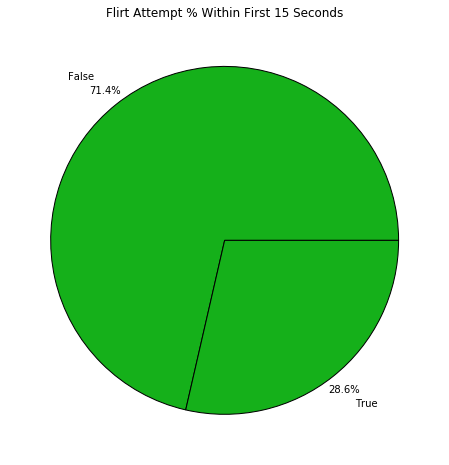

In [6]:
data_properties = query(
    scl5_replays,
    DataQueryProperties(query_function=_flirt_in_15_seconds),
    AxisProperties(
        title='Flirt Attempt % Within First 15 Seconds',
        savefig='example_pictures/example_flirt_15.png')
)

In [7]:
def _first_mission_completed(games, data_dictionary):
    for game in games:
        first_mission = Missions.Zero
        for timeline_event in game.timeline:
            if timeline_event.category & TimelineCategory.MissionComplete:
                first_mission = timeline_event.mission
                break

        data_dictionary[first_mission] += 1

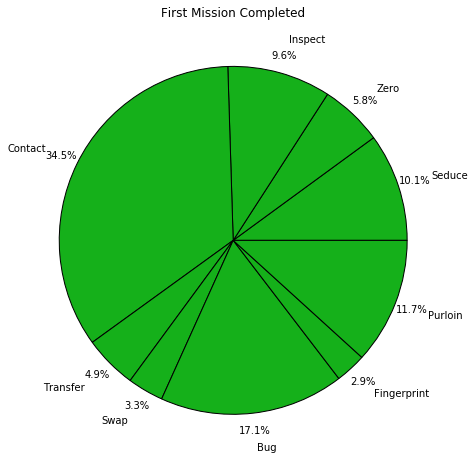

In [8]:
data_properties = query(
    scl5_replays,
    DataQueryProperties(query_function=_first_mission_completed),
    AxisProperties(
        title='First Mission Completed',
        savefig='example_pictures/example_first_mission.png')
)

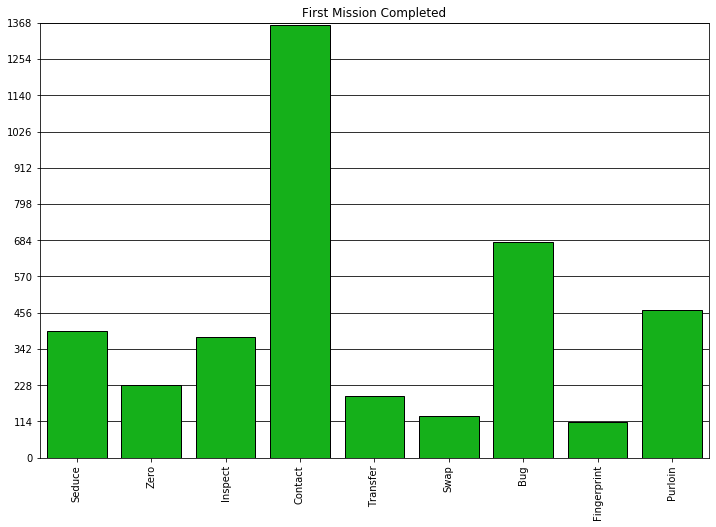

In [9]:
data_properties = query(
    scl5_replays,
    DataQueryProperties(query_function=_first_mission_completed),
    AxisProperties(title='First Mission Completed', force_bar=True)
)

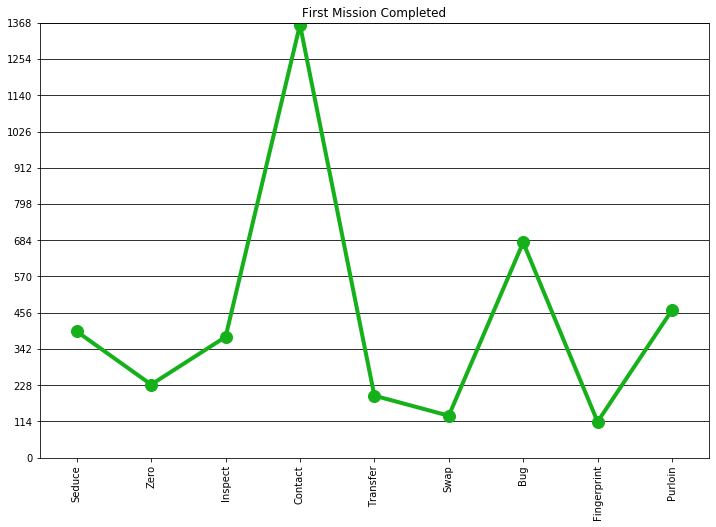

In [10]:
data_properties = query(
    scl5_replays,
    DataQueryProperties(query_function=_first_mission_completed),
    AxisProperties(title='First Mission Completed', force_line=True)
)